In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm
import os
import random
from sklearn.manifold import TSNE

In [2]:
domains = ["Art", "Clip Art", "Real World"]

NUM_CLASSES = 65
BATCH_SIZE = 32
NUM_EPOCHS = 5
LEARNING_RATE = 0.001
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [3]:
d_t = "Art"
d_s = "Real World"

device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


In [4]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    model.to(device)
    model.train()
    losses = []
    accuracies = []
    for x, y in tqdm(dataloader):
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)
        losses.append(loss.item())
        accuracies.append((pred.argmax(1) == y).float().mean().item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return np.mean(losses), np.mean(accuracies)

def evaluate(dataloader, model, loss_fn, device):
    model.to(device)
    model.eval()
    losses = []
    accuracies = []
    with torch.no_grad():
        for x, y in tqdm(dataloader):
            x, y = x.to(device), y.to(device)

            pred = model(x)
            loss = loss_fn(pred, y)

            losses.append(loss.item())
            accuracies.append((pred.argmax(1) == y).float().mean().item())
    return np.mean(losses), np.mean(accuracies)

In [5]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

source_folder = os.path.join("officehome", d_s)
target_folder = os.path.join("officehome", d_t)

train_dataset = torchvision.datasets.ImageFolder(source_folder, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(target_folder, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [6]:
with torch.serialization.safe_globals([torchvision.models.resnet50()]):
    model = torch.load("resnet50_base.pth", weights_only=False)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()


In [7]:
def compute_filtered_dataset(model, dataloader, threshold_prob=0.85, device="cpu"):
    model.eval()
    # Compute pseudo-labels without gradients
    all_imgs = []
    all_labels = []
    with torch.no_grad():
        for x, _ in tqdm(dataloader):
            x = x.to(device)
            pred = model(x)
            predictions = torch.softmax(pred, dim=1)
            max_probs, pseudo_labels = torch.max(predictions, dim=1)
            mask = max_probs >= threshold_prob

            # collect filtered samples
            imgs = x[mask].cpu()
            labels = pseudo_labels[mask].cpu()
            all_imgs.append(imgs)
            all_labels.append(labels)

    # stack everything outside no_grad
    if len(all_imgs) == 0:
        return []

    all_imgs = torch.cat(all_imgs)
    all_labels = torch.cat(all_labels)

    # return a dataset that will yield tensors properly during training
    dataset = torch.utils.data.TensorDataset(all_imgs, all_labels)
    return dataset


In [8]:
threshold_prob = 0.9
pseudo_train_losses = []
pseudo_train_accuracies = []
for i in range(NUM_EPOCHS):
    data = compute_filtered_dataset(model, test_loader, threshold_prob=threshold_prob, device=device)
    if len(data) == 0:
        print("No pseudo-labeled data above the threshold. Stopping training.")
        break
    print(len(data))
    dataloader = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)
    train_loss, train_acc = train_loop(dataloader, model, loss_fn, optimizer, device)
    print(f"Epoch {i+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    threshold_prob += 0.01
    pseudo_train_losses.append(train_loss)
    pseudo_train_accuracies.append(train_acc)

100%|██████████| 76/76 [00:25<00:00,  3.03it/s]


354


100%|██████████| 12/12 [00:07<00:00,  1.60it/s]


Epoch 1/5, Train Loss: 0.8204, Train Acc: 0.7786


100%|██████████| 76/76 [00:23<00:00,  3.25it/s]


762


100%|██████████| 24/24 [00:14<00:00,  1.61it/s]


Epoch 2/5, Train Loss: 0.5525, Train Acc: 0.8452


100%|██████████| 76/76 [00:23<00:00,  3.27it/s]


919


100%|██████████| 29/29 [00:16<00:00,  1.78it/s]


Epoch 3/5, Train Loss: 0.3719, Train Acc: 0.8886


100%|██████████| 76/76 [00:23<00:00,  3.24it/s]


997


100%|██████████| 32/32 [00:18<00:00,  1.68it/s]


Epoch 4/5, Train Loss: 0.3854, Train Acc: 0.8693


100%|██████████| 76/76 [00:23<00:00,  3.26it/s]


1029


100%|██████████| 33/33 [00:18<00:00,  1.80it/s]

Epoch 5/5, Train Loss: 0.2841, Train Acc: 0.9138


In [9]:
source_loss, source_acc = evaluate(train_loader, model, loss_fn, device)
print(f"Source Domain ({d_s}) - Loss: {source_loss:.4f}, Accuracy: {source_acc:.4f}")
test_loss, test_acc = evaluate(test_loader, model, loss_fn, device)
print(f"Final Test Loss: {test_loss:.4f}, Final Test Acc: {test_acc:.4f}")

100%|██████████| 137/137 [01:10<00:00,  1.95it/s]


Source Domain (Real World) - Loss: 6.8626, Accuracy: 0.2160


100%|██████████| 76/76 [00:24<00:00,  3.12it/s]

Final Test Loss: 10.1703, Final Test Acc: 0.1228


In [10]:
torch.save(model.state_dict(), f"resnet50_pseudo_labels.pth")

# Concept Shift

In [11]:
def simulate_concept_shift(source_dataset, target_dataset, rare_fraction=0.2, removed_classes=5):
    np.random.seed(42)
    random.seed(42)

    # Unique class indices
    classes = list(range(len(source_dataset.classes)))

    # Pick random classes to remove from target (simulate label shift)
    removed = random.sample(classes, removed_classes)
    print(f"Removed classes from target: {removed}")

    # Rare class (under-represented)
    rare_class = random.choice([c for c in classes if c not in removed])
    print(f"Rare class in target: {rare_class}")

    # --- Filter target indices ---
    target_indices = []
    for i, (_, label) in enumerate(target_dataset):
        if label not in removed:
            if label == rare_class:
                # Keep only a small fraction of rare class
                if np.random.rand() < rare_fraction:
                    target_indices.append(i)
            else:
                target_indices.append(i)

    shifted_target = torch.utils.data.Subset(target_dataset, target_indices)
    return shifted_target


In [12]:
shifted_target_dataset = simulate_concept_shift(train_dataset, test_dataset, rare_fraction=0.2, removed_classes=5)
shifted_target_loader = torch.utils.data.DataLoader(shifted_target_dataset, batch_size=BATCH_SIZE, shuffle=True)

with torch.serialization.safe_globals([torchvision.models.resnet50()]):
    model = torch.load("resnet50_base.pth", weights_only=False)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

Removed classes from target: [14, 3, 35, 31, 28]
Rare class in target: 9


In [13]:
threshold_prob = 0.9
pseudo_train_losses = []
pseudo_train_accuracies = []
for i in range(NUM_EPOCHS):
    data = compute_filtered_dataset(model, test_loader, threshold_prob=threshold_prob, device=device)
    if len(data) == 0:
        print("No pseudo-labeled data above the threshold. Stopping training.")
        break
    print(len(data))
    dataloader = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)
    train_loss, train_acc = train_loop(dataloader, model, loss_fn, optimizer, device)
    print(f"Epoch {i+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    threshold_prob += 0.01
    pseudo_train_losses.append(train_loss)
    pseudo_train_accuracies.append(train_acc)

100%|██████████| 76/76 [00:24<00:00,  3.13it/s]


354


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]


Epoch 1/5, Train Loss: 0.7282, Train Acc: 0.8099


100%|██████████| 76/76 [00:23<00:00,  3.25it/s]


877


100%|██████████| 28/28 [00:17<00:00,  1.58it/s]


Epoch 2/5, Train Loss: 0.5519, Train Acc: 0.8467


100%|██████████| 76/76 [00:24<00:00,  3.14it/s]


947


100%|██████████| 30/30 [00:18<00:00,  1.65it/s]


Epoch 3/5, Train Loss: 0.2842, Train Acc: 0.9104


100%|██████████| 76/76 [00:24<00:00,  3.08it/s]


977


100%|██████████| 31/31 [00:19<00:00,  1.55it/s]


Epoch 4/5, Train Loss: 0.3051, Train Acc: 0.9087


100%|██████████| 76/76 [00:24<00:00,  3.14it/s]


900


100%|██████████| 29/29 [00:18<00:00,  1.57it/s]

Epoch 5/5, Train Loss: 0.4168, Train Acc: 0.8761


In [14]:
source_loss, source_acc = evaluate(train_loader, model, loss_fn, device)
print(f"Source Domain ({d_s}) - Loss: {source_loss:.4f}, Accuracy: {source_acc:.4f}")
test_loss, test_acc = evaluate(test_loader, model, loss_fn, device)
print(f"Final Test Loss: {test_loss:.4f}, Final Test Acc: {test_acc:.4f}")

100%|██████████| 137/137 [01:09<00:00,  1.96it/s]


Source Domain (Real World) - Loss: 7.2533, Accuracy: 0.2032


100%|██████████| 76/76 [00:23<00:00,  3.17it/s]

Final Test Loss: 10.4876, Final Test Acc: 0.1302


In [17]:
torch.save(model.state_dict(), f"resnet50_pseudo_labels_cs.pth")

# Visualisation

In [18]:
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model.load_state_dict(torch.load(f"resnet50_pseudo_labels.pth"))

<All keys matched successfully>

In [19]:
features_map = []
labels = []

def get_feature():
    def hook(model, input, output):
        features_map.append(output.detach().cpu())
    return hook

# Register hook
model_hook = model.avgpool.register_forward_hook(get_feature())

model.to(device)
model.eval()

def extract_features(loader, max_samples=1000):
    features_map.clear()
    labels.clear()

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            _ = model(x)
            labels.extend(y.cpu().numpy())

            if len(labels) >= max_samples:
                break

    features = torch.cat(features_map, dim=0).view(len(labels), -1)[:max_samples]
    return features, labels[:max_samples]

# --- Extract features for train and test ---
train_features, train_labels = extract_features(train_loader, max_samples=1000)
test_features, test_labels = extract_features(test_loader, max_samples=1000)

# Remove hook after done
model_hook.remove()

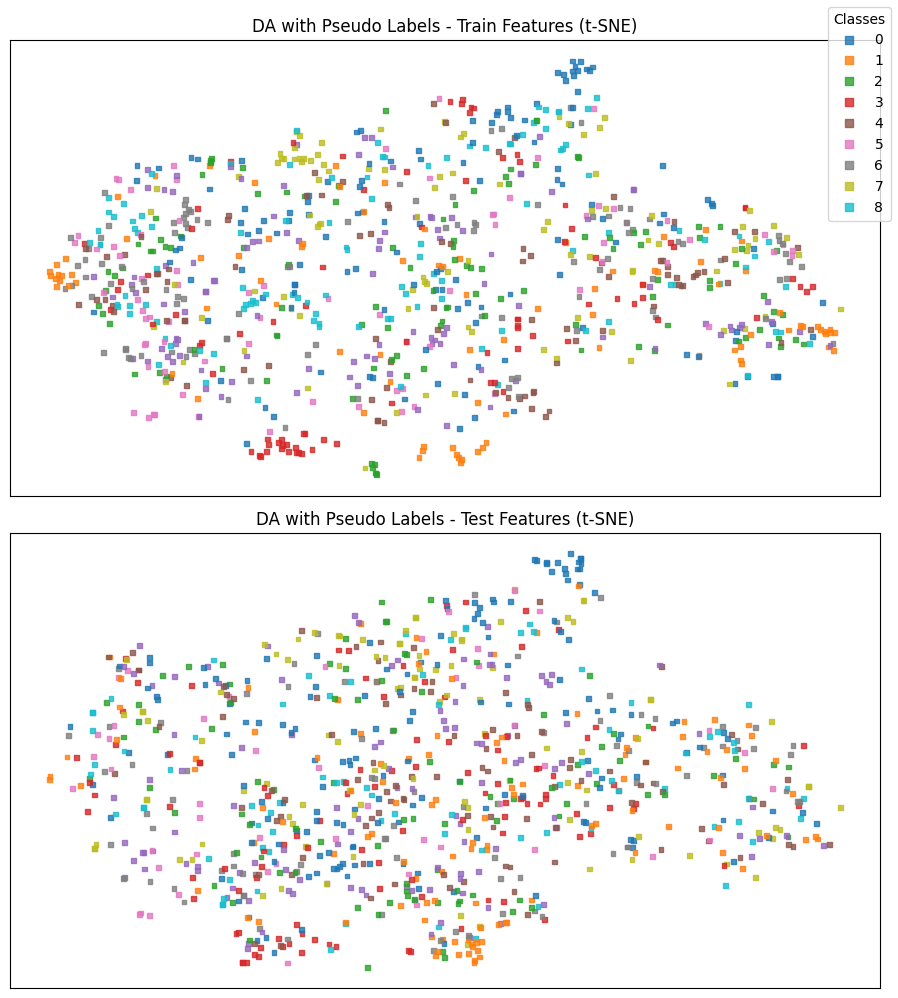

In [21]:
def plot_tsne(train_features, train_labels, test_features, test_labels, perplexity=30, random_state=42):
    # Convert tensors to numpy
    train_features = train_features.cpu().numpy() if hasattr(train_features, "cpu") else np.array(train_features)
    test_features = test_features.cpu().numpy() if hasattr(test_features, "cpu") else np.array(test_features)
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)

    # Joint t-SNE for consistent space
    combined_features = np.concatenate([train_features, test_features], axis=0)
    combined_2d = TSNE(n_components=2, perplexity=perplexity, random_state=random_state).fit_transform(combined_features)

    n_train = len(train_features)
    train_2d, test_2d = combined_2d[:n_train], combined_2d[n_train:]

    # --- Plot side-by-side ---
    fig, axes = plt.subplots(2, 1, figsize=(9, 10))

    scatter_train = axes[0].scatter(train_2d[:, 0], train_2d[:, 1],
                                    c=train_labels, cmap="tab10", s=12, marker='s', alpha=0.8)
    axes[0].set_title("DA with Pseudo Labels - Train Features (t-SNE)")
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    scatter_test = axes[1].scatter(test_2d[:, 0], test_2d[:, 1],
                                   c=test_labels, cmap="tab10", s=12, marker='s', alpha=0.8)
    axes[1].set_title("DA with Pseudo Labels - Test Features (t-SNE)")
    axes[1].set_xticks([])
    axes[1].set_yticks([])

    # Shared legend for class colors
    handles, _ = scatter_train.legend_elements(prop="colors")
    fig.legend(handles, np.unique(train_labels), title="Classes", loc="upper right")

    plt.tight_layout()
    plt.show()

plot_tsne(train_features, train_labels, test_features, test_labels)